## MNIST

I am just following the example from github

In [1]:
from flax import linen as nn

class CNN(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

In [2]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
train_ds['image'] = jnp.float32(train_ds['image']) / 255.0
test_ds['image'] = jnp.float32(test_ds['image']) / 255.0

2024-07-14 21:34:14.722793: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 21:34:14.722820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 21:34:14.722827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 21:34:16.888741: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-14 21:34:17.743928: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.1 which is older than the

In [3]:
rng = jax.random.PRNGKey(666)
rng, init_rng = jax.random.split(rng)

print(rng, init_rng)

[3821355411 1052689499] [ 472701702 1383871100]


In [4]:
from flax.training import train_state
import optax

def create_train_state(rng, **config):
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(config['learning_rate'])
  return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)


config = {
  'learning_rate': 1e-3,
}
state = create_train_state(rng, **config)
print(state)

TrainState(step=0, apply_fn=<bound method Module.apply of CNN()>, params={'Conv_0': {'kernel': Array([[[[-1.87883079e-01, -3.66046876e-01, -7.26797879e-01,
           1.51357740e-01, -1.11875981e-01,  2.58723706e-01,
           4.06527758e-01,  4.02860641e-01,  7.54067123e-01,
           1.79948971e-01, -7.79667031e-03,  1.14653714e-01,
           2.98193812e-01, -3.32968563e-01, -9.53881890e-02,
          -1.29700854e-01, -3.02171350e-01,  2.38647178e-01,
           3.79982322e-01,  1.89356878e-01, -3.52581918e-01,
           1.71815470e-01, -6.30969286e-01, -3.64484727e-01,
          -2.31885716e-01,  1.35227576e-01, -6.91583872e-01,
           2.68600732e-01, -3.58597845e-01,  9.39052776e-02,
           3.92303705e-01, -2.64766842e-01]],

        [[ 3.54828864e-01, -2.18503606e-02, -3.43826532e-01,
           1.92753822e-01, -5.60924172e-01, -4.55228955e-01,
          -4.83428270e-01,  3.24279010e-01,  5.80015481e-01,
           1.88834280e-01,  1.88696265e-01,  1.44902011e-02,
    

In [5]:
@jax.jit
def apply_model(state, images, labels):
  def loss_fn(params):
    logits = CNN().apply({'params': params}, images)
    one_hot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits
  
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, loss, accuracy


BATCH_SIZE = 1024
test_images = train_ds['image'][:BATCH_SIZE]
test_labels = train_ds['label'][:BATCH_SIZE]
grads, loss, accuracy = apply_model(state, test_images, test_labels)
print(loss)
print(accuracy)

2.3120646
0.13085938


In [6]:
import numpy as np

@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)


def train_epoch(state):
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // BATCH_SIZE

  indices = np.arange(len(train_ds['image']))
  perms = np.random.permutation(indices)
  perms = perms[:steps_per_epoch * BATCH_SIZE]
  perms = perms.reshape((steps_per_epoch, BATCH_SIZE))
  epoch_loss = []
  epoch_accuracy = []
  for perm in perms:
    batch_images = train_ds['image'][perm, ...]
    batch_labels = train_ds['label'][perm, ...]
    grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
    state = update_model(state, grads)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy


def evaluate(test_images, test_labels):
  losses = []
  accuracy = []
  size = len(test_images)
  for i in range(0, size, BATCH_SIZE):
    img = test_images[i:i+BATCH_SIZE]
    lbl = test_labels[i:i+BATCH_SIZE]
    _, l, a = apply_model(state, img, lbl)
    losses.append(l)
    accuracy.append(a)
  return sum(losses) / len(losses), sum(accuracy) / len(accuracy)


def train_and_evaluate(state):
  for epoch in range(1, 11):
    state, train_loss, train_accuracy = train_epoch(state)
    test_loss, test_accuracy = evaluate(test_ds['image'], test_ds['label'])
    print(f'epoch: {epoch}, train_loss: {train_loss}, train_accuracy: {train_accuracy * 100}, test_loss: {test_loss} test_accuracy: {test_accuracy * 100}')
  return state


done_state = train_and_evaluate(state)

epoch: 1, train_loss: 0.5213262438774109, train_accuracy: 86.181640625, test_loss: 2.3079466819763184 test_accuracy: 13.396842956542969
epoch: 2, train_loss: 0.14243026077747345, train_accuracy: 95.9135890007019, test_loss: 2.3079466819763184 test_accuracy: 13.396842956542969
epoch: 3, train_loss: 0.08698924630880356, train_accuracy: 97.47777581214905, test_loss: 2.3079466819763184 test_accuracy: 13.396842956542969
epoch: 4, train_loss: 0.0633610263466835, train_accuracy: 98.15126657485962, test_loss: 2.3079466819763184 test_accuracy: 13.396842956542969
epoch: 5, train_loss: 0.0515194796025753, train_accuracy: 98.48969578742981, test_loss: 2.3079466819763184 test_accuracy: 13.396842956542969
epoch: 6, train_loss: 0.043793972581624985, train_accuracy: 98.6934244632721, test_loss: 2.3079466819763184 test_accuracy: 13.396842956542969
epoch: 7, train_loss: 0.03744197636842728, train_accuracy: 98.91231060028076, test_loss: 2.3079466819763184 test_accuracy: 13.396842956542969
epoch: 8, train

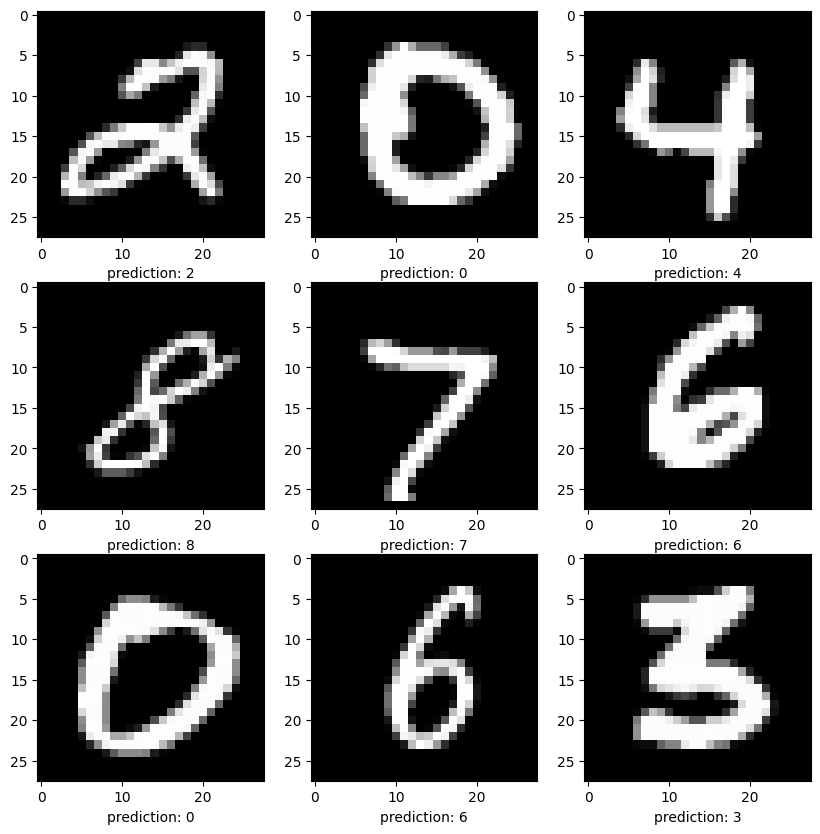

In [7]:
import matplotlib.pyplot as plt

test_images = test_ds['image'][:9, ...]
logits = CNN().apply({'params': done_state.params}, test_images)
prediction = logits.argmax(axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(test_images[i, :, :, 0], cmap='gray')
  plt.xlabel('prediction: ' + str(prediction[i]))
plt.show()

In [8]:
import os
import shutil

if os.path.isdir('/tmp/mnist/chkpoint'):
  shutil.rmtree('/tmp/mnist/chkpoint')

In [9]:
from flax.training import orbax_utils
import orbax.checkpoint
import os

ckpt = {'model': state, 'config': config}

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('/tmp/mnist/chkpoint', ckpt, save_args=save_args)